In [1]:
import getpass
username = getpass.getuser()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import sys
sys.path.append('/Users/{:}/GitHub/mouse_bandit/data_preprocessing_code'.format(username))
sys.path.append('/Users/{:}/GitHub/mouse_bandit'.format(username))
import support_functions as sf

sys.path.append('/Users/{:}/GitHub/mouse_bandit/jupyter_notebooks/helper_functions'.format(username))
import bandit_modeling as bm

% matplotlib inline

In [16]:
data = pd.read_csv('/Users/{:}/Dropbox (HMS)/mouse_bandit/markov_full.csv'.format(username), index_col=0)
#data = data[data['Condition']=='90-10']
data = data[data['Mouse ID']=='Baby']

In [17]:
greedy_predict, beliefs = bm.hmm_predict(data, 0.7)

'''Greedy model'''

decision = data['Decision'].values
prev_decision = data['1_Port'].values

switch = np.abs(decision-prev_decision)
greedy_switch = np.abs(greedy_predict-prev_decision)

accuracy_greedy = np.mean(greedy_predict==decision)
print('accuracy = ', accuracy_greedy)

precision_greedy=1-np.abs([greedy_switch[i]-switch[i] for i in np.where(greedy_switch==1)]).sum()/np.sum(greedy_switch==1)
print('precision =', precision_greedy)

recall_greedy=1-np.abs([greedy_switch[i]-switch[i] for i in np.where(switch==1)]).sum()/np.sum(switch==1)
print('recall =', recall_greedy)

acc_greedy_switch,acc_greedy_stay,F1=sf.score_both_and_confuse(greedy_switch,switch,confusion=False,disp=True)

accuracy =  0.869045392194
precision = 0.264728725175
recall = 0.573557692308
          Predicted NO  Predicted YES
True NO        53365.0         6627.0
True YES        1774.0         2386.0

F1: 0.362

Accuracy on class 0: 0.89
Accuracy on class 1: 0.57



In [18]:
greedy_switch = np.abs(greedy_predict-prev_decision)
metrics_greedy  = sklearn.metrics.precision_recall_fscore_support(switch, greedy_switch)

In [19]:
thompson_predict, beliefs = bm.hmm_predict(data, 0.7, strategy='thompson')

thompson_switch = np.abs(thompson_predict-prev_decision)

accuracy_thom = np.mean(thompson_predict==decision)
#accuracy=1-np.abs([y_predict[i]-decision[i] for i in range(len(beliefs))]).sum()/len(beliefs)
print('accuracy = ', accuracy_thom)

precision_thom=1-np.abs([thompson_switch[i]-switch[i] for i in np.where(thompson_switch==1)]).sum()/np.sum(thompson_switch==1)
print('precision =', precision_thom)

recall_thom=1-np.abs([thompson_switch[i]-switch[i] for i in np.where(switch==1)]).sum()/np.sum(switch==1)
print('recall =', recall_thom)

acc_thom_switch,acc_thom_stay,F1=sf.score_both_and_confuse(thompson_switch,switch,confusion=False,disp=True)

accuracy =  0.80906285073
precision = 0.183355515541
recall = 0.562980769231
          Predicted NO  Predicted YES
True NO        49561.0        10431.0
True YES        1818.0         2342.0

F1: 0.277

Accuracy on class 0: 0.83
Accuracy on class 1: 0.56



In [20]:
metrics_thompson = sklearn.metrics.precision_recall_fscore_support(switch, thompson_switch)

In [22]:
X, y, c = bm.feature_history(data, X_dataframe='choice', y_dataframe='choice')
X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(X, y, c, test_size=0.3, random_state=1)

lr1_choice = LogisticRegression()
lr1_choice.fit(X_train, y_train)

lr1_choice_predict = lr1_choice.predict(X_test)

prev_choice = c_test['1_Port']
true_switch = (y_test!=prev_choice).astype('int')
lr1_switch_predict = (lr1_choice_predict!=prev_choice).astype('int')
metrics_lr1 = sklearn.metrics.precision_recall_fscore_support(true_switch, lr1_switch_predict)

accuracy_lr1 = np.mean(true_switch==lr1_switch_predict)

acc_pos,acc_neg,F1=sf.score_both_and_confuse(lr1_switch_predict.values,true_switch.values,confusion=False,disp=True)

          Predicted NO  Predicted YES
True NO        17527.0          449.0
True YES         891.0          379.0

F1: 0.361

Accuracy on class 0: 0.98
Accuracy on class 1: 0.30



In [23]:
X_left, X_right, y_left, y_right, c = bm.choice_history_lateral(data)

'''RIGHT'''

X_train, X_test, y_train, y_test = train_test_split(X_right, y_right, test_size=0.3, random_state=1)

lr2 = LogisticRegression()
lr2.fit(X_train, y_train)
    
lr2_proba_R = lr2.predict_proba(X_test)

'''LEFT'''
X_train, X_test, y_train, y_test = train_test_split(X_left, y_left, test_size=0.3, random_state=1)

lr2 = LogisticRegression()
lr2.fit(X_train, y_train)

lr2_proba_L = lr2.predict_proba(X_test)

'''INTEGRATED'''
# go to whichever port has a higher probability from its model
c_train, c_test = train_test_split(c, test_size=0.3, random_state=1)

lr2_proba = np.row_stack((lr2_proba_L[:,1],lr2_proba_R[:,1]))

y_predict = lr2_proba_L[:,1]>lr2_proba_R[:,1] # predict 1s for L, 0s for R
    
lr2_score=1-np.abs(y_predict-y_test).sum()/len(y_test)
    
prev_choice = c_test['1_Port']
s_predict = (np.abs(y_predict-prev_choice)).astype('int')
s_test = np.abs(y_test-prev_choice).astype('int')
    
accuracy_lr2 = np.mean(s_test==s_predict)    
    
metrics_lr2 = sklearn.metrics.precision_recall_fscore_support(s_test, s_predict)

In [24]:
'''win stay lose switch'''

prev_outcome = data['1_Reward'].values
wsls_predict = np.abs(1-prev_outcome)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(wsls_predict,switch,confusion=False,disp=True)

wsls = np.mean(switch[np.where(prev_outcome==0)])
print('fraction switches after unrewarded =', wsls)

accuracy_wsls = np.mean(wsls_predict==switch)

precision_wsls = 1-np.abs([wsls_predict[i]-switch[i] for i in np.where(wsls_predict==1)]).sum()/np.sum(wsls_predict==1)
print('precision =', precision_wsls)

recall_wsls=1-np.abs([wsls_predict[i]-switch[i] for i in np.where(switch==1)]).sum()/np.sum(switch==1)
print('recall =', recall_wsls)

metrics_wsls = sklearn.metrics.precision_recall_fscore_support(switch, wsls_predict)

          Predicted NO  Predicted YES
True NO        43915.0        16077.0
True YES         676.0         3484.0

F1: 0.294

Accuracy on class 0: 0.73
Accuracy on class 1: 0.84

fraction switches after unrewarded = 0.178109503604
precision = 0.178109503604
recall = 0.8375


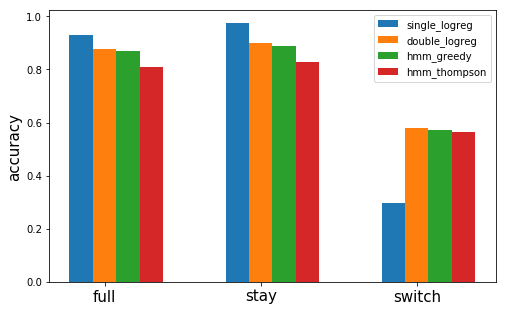

In [33]:
plt.figure(figsize=(8,5))

height_a = [accuracy_lr1, metrics_lr1[1][0], metrics_lr1[1][1]]
height_b = [accuracy_lr2, metrics_lr2[1][0], metrics_lr2[1][1]]
height_c = [accuracy_greedy, acc_greedy_stay, acc_greedy_switch]
height_d = [accuracy_thom, acc_thom_stay, acc_thom_switch]

barWidth = 0.15
# The x position of bars
r1 = np.arange(len(height_b))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

conditions = ['full', 'stay', 'switch']
plt.bar(r1, height_a, width=barWidth, label='single_logreg')
plt.bar(r2, height_b, width=barWidth, label='double_logreg')
plt.bar(r3, height_c, width=barWidth, label='hmm_greedy')
plt.bar(r4, height_d, width=barWidth, label='hmm_thompson')

plt.xticks(r2, conditions, size=15)
plt.ylabel('accuracy', size=15)
plt.legend(bbox_to_anchor=(1,1))

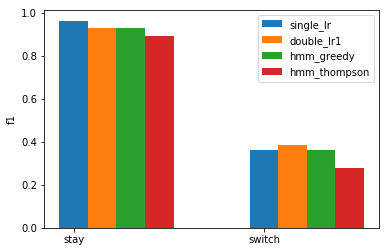

In [26]:
height_a = [metrics_lr1[2][0], metrics_lr1[2][1]]
height_b = [metrics_lr2[2][0], metrics_lr2[2][1]]
height_c = [metrics_greedy[2][0], metrics_greedy[2][1]]
height_d = [metrics_thompson[2][0], metrics_thompson[2][1]]

barWidth = 0.15
# The x position of bars
r1 = np.arange(len(height_b))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

conditions = ['stay', 'switch']
plt.bar(r1, height_a, width=barWidth, label='single_lr')
plt.bar(r2, height_b, width=barWidth, label='double_lr1')
plt.bar(r3, height_c, width=barWidth, label='hmm_greedy')
plt.bar(r4, height_d, width=barWidth, label='hmm_thompson')

plt.xticks(range(len(height_b)), conditions)
plt.ylabel('f1')
plt.legend()

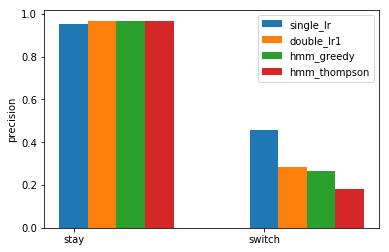

In [27]:
height_a = [metrics_lr1[0][0], metrics_lr1[0][1]]
height_b = [metrics_lr2[0][0], metrics_lr2[0][1]]
height_c = [metrics_greedy[0][0], metrics_greedy[0][1]]
height_d = [metrics_thompson[0][0], metrics_thompson[0][1]]

barWidth = 0.15
# The x position of bars
r1 = np.arange(len(height_b))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

conditions = ['stay', 'switch']
plt.bar(r1, height_a, width=barWidth, label='single_lr')
plt.bar(r2, height_b, width=barWidth, label='double_lr1')
plt.bar(r3, height_c, width=barWidth, label='hmm_greedy')
plt.bar(r4, height_d, width=barWidth, label='hmm_thompson')

plt.xticks(range(len(height_b)), conditions)
plt.ylabel('precision')
plt.legend()

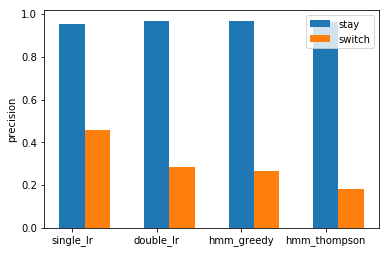

In [28]:
height_a = [metrics_lr1[0][0], metrics_lr2[0][0], metrics_greedy[0][0], metrics_thompson[0][0]]
height_b = [metrics_lr1[0][1], metrics_lr2[0][1], metrics_greedy[0][1], metrics_thompson[0][1]]

barWidth = 0.3
# The x position of bars
r1 = np.arange(len(height_a))
r2 = [x + barWidth for x in r1]

conditions = ['single_lr', 'double_lr', 'hmm_greedy', 'hmm_thompson']
plt.bar(r1, height_a, width=barWidth, label='stay')
plt.bar(r2, height_b, width=barWidth, label='switch')

plt.xticks(range(len(height_a)), conditions)
plt.ylabel('precision')
plt.legend()